In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster
from core.utils import used_keys

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD', 'misBAD',
    'ssbCCM','ssbCCD'    
]


linkage = 'complete'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [3]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar, read_extra=False):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)


    if read_extra:
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        vals = scalar.fit_transform(extra_chars)
        extra_chars = pd.DataFrame(vals, columns=extra_chars.columns, index=extra_chars.index).fillna(0)
        extra_chars = extra_chars.drop(component_data.columns[component_data.std() == 0], axis=1)
        extra_chars = extra_chars[['limLPS']]
        extra_chars['limLPS2'] = extra_chars['limLPS']

        merged_data = pd.merge(component_data, extra_chars, how='inner', left_index=True, right_index=True)
        pd.testing.assert_index_equal(merged_data.index, component_data.index)
        component_data = merged_data
    
    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def read_morphotopes_chars():
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        data.append(extra_chars)
    
    data = pd.concat(data)
    return data 

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:

regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [5]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
scalar = QuantileTransformer(subsample=None, output_distribution='uniform')


In [6]:
# %%time

## generate and save linkage matricies for each region
for region_id, _ in region_hulls.iterrows():
    data = read_region_morphotope_data(region_id, scalar, read_extra=True)
    linkage_matrix = get_morphotope_linkage(data)
    np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (189). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (189). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (179). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (179). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (205). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (205). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (274). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (274). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 1970
processing 1981
processing 2096
processing 2322
processing 2350


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (72). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (163). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (163). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (208). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (208). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (316). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (325). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (325). n_quantiles is set to n_samples.
  warnings.warn(


processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (130). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (130). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (326). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (326). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (276). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (276). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (86). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (977). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 5427
processing 5662
processing 5671
processing 5766
processing 5883


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (190). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (190). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (613). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 6254
processing 6529
processing 6560
processing 6576


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (145). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (55). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (55). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (437). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 6741
processing 6749
processing 6811
processing 6873
processing 6996
processing 7068
processing 7094
processing 7280
processing 7485
processing 7528
processing 7534
processing 7681
processing 7688
processing 7712
processing 7727


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (77). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (77). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (525). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (525). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 7805
processing 7914
processing 7937
processing 7963
processing 8046
processing 8216


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (719). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (189). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (189). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (82). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urba

processing 8238
processing 8256
processing 8265
processing 8345
processing 8374
processing 8396
processing 8592


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (492). n_quantiles is set to n_samples.
  warnings.warn(


processing 8707
processing 8731
processing 8757
processing 8759
processing 8813
processing 9016
processing 9064
processing 9074


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (494). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (494). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (288). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (288). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 9150
processing 9169
processing 9194
processing 9284
processing 9824


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (332). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (332). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (551). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (551). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 9924
processing 9954
processing 9972


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (265). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (265). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (369). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (369). n_quantiles is set to n_samples.
  warnings.warn(


processing 10019
processing 10086
processing 10095
processing 10124
processing 10179
processing 10222
processing 10263
processing 10277


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (189). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (189). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 10455
processing 10510
processing 10511
processing 10563
processing 10579


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (301). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (301). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (190). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (190). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 10602
processing 10666
processing 10794
processing 10847
processing 10908
processing 10926
processing 10970
processing 11002


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (223). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (223). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (226). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (226). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 11019
processing 11057
processing 11141
processing 11210
processing 11256
processing 11261
processing 11305
processing 11309


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (117). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (117). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (119). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (119). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 11311
processing 11318
processing 11367
processing 11444
processing 11455
processing 11471
processing 11667


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (443). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (158). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (158). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (166). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 11678
processing 11735
processing 11757
processing 11799
processing 11877
processing 11905


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (168). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (168). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (219). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (219). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 12027
processing 12084
processing 12100


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (367). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (137). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (137). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (126). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 12115
processing 12154
processing 12191
processing 12381
processing 12440


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (143). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (143). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (181). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (181). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 12483
processing 12552
processing 12667
processing 12707
processing 12755
processing 12756
processing 12844


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (203). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (574). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (574). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 12919
processing 12965
processing 13076
processing 13137
processing 13172
processing 13191
processing 13196


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (114). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (114). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (431). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (431). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 13229
processing 13301
processing 13395
processing 13442
processing 13482
processing 13506
processing 13553


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (152). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (152). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (82). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (82). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 13555
processing 13614
processing 13616
processing 13655
processing 13677
processing 13779
processing 13810


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (413). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (413). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (214). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (214). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 13881
processing 13897
processing 13965
processing 14084
processing 14245
processing 14319
processing 14321


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (531). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (395). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (395). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (242). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 14327
processing 14364
processing 14383
processing 14550
processing 14552
processing 14623
processing 14679
processing 14702
processing 14735
processing 14789
processing 14933
processing 15019
processing 15139
processing 15265


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (91). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (91). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (133). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 15331
processing 15347
processing 15484
processing 15509
processing 15545
processing 15555
processing 15613
processing 15626
processing 15653


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (143). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (143). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (138). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (138). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 15690
processing 15716
processing 15794
processing 15802
processing 15933
processing 15970
processing 16217
processing 16242
processing 16256
processing 16291
processing 16318
processing 16429
processing 16509
processing 16510


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (179). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (179). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 16566
processing 16632
processing 16685
processing 16688


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (147). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (147). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 16745
processing 16921
processing 17171
processing 17268
processing 17389
processing 17393
processing 17458


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (269). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (269). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (635). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (635). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 17677
processing 17690
processing 17959
processing 18008
processing 18164
processing 18454
processing 18489


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (603). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (603). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (182). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (182). n_quantiles is set to n_samples.
  warnings.warn(


processing 18516
processing 18557
processing 18893
processing 19124
processing 19151
processing 19244
processing 19254
processing 19376
processing 19386


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (433). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (433). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (553). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (553). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 19393
processing 19542
processing 19878
processing 19940
processing 20123
processing 20149


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (742). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (742). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (344). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (344). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 20243
processing 20496
processing 20554
processing 20783
processing 20968


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (383). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (383). n_quantiles is set to n_samples.
  warnings.warn(


processing 20970
processing 21174
processing 21304
processing 21484
processing 21523
processing 21569
processing 21591


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (363). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (363). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (274). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (274). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 21894
processing 21904
processing 22040
processing 22105


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (522). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (176). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (176). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 22345
processing 22602
processing 22704
processing 22884
processing 22912
processing 22976


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (465). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (465). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (206). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (206). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 23258
processing 23337
processing 23401


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (383). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (383). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (191). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (191). n_quantiles is set to n_samples.
  warnings.warn(


processing 23631
processing 23642
processing 23661
processing 23812
processing 23984
processing 24116
processing 24232


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (491). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (491). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 24257
processing 24276
processing 24389
processing 24402
processing 24596


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (929). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (744). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (744). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (650). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 24735
processing 24743
processing 25202
processing 25361
processing 25491


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (457). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (214). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (214). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (536). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 25532
processing 25656
processing 25697
processing 25765
processing 25934
processing 26072
processing 26265
processing 26300
processing 26315
processing 26429
processing 26435


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (573). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (573). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 26468
processing 26780
processing 26888
processing 27053
processing 27166


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (678). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (678). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (654). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (654). n_quantiles is set to n_samples.
  warnings.warn(


processing 27178
processing 27297
processing 27411
processing 27578


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (555). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (555). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (377). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (377). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 27587
processing 27717
processing 27773
processing 27926
processing 28040


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (577). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (577). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (154). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (154). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 28235
processing 28307
processing 28566
processing 28835
processing 29096
processing 29215


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (757). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (757). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (157). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (157). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 29249
processing 29278
processing 29344
processing 29374
processing 29694
processing 29729


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (343). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (470). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (470). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (440). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 29787
processing 29800
processing 29984
processing 30124
processing 30213


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (113). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (113). n_quantiles is set to n_samples.
  warnings.warn(


processing 30523
processing 30585
processing 30615
processing 30640
processing 30729


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (599). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (599). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (687). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (687). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 30754
processing 30775
processing 30841
processing 31212
processing 31237
processing 31287
processing 31291
processing 31298
processing 31736


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (890). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (890). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 32023
processing 32045
processing 32108
processing 32261


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (350). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (350). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (313). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (313). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 32386
processing 32427
processing 32503
processing 32593
processing 32685
processing 32793


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (312). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (671). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (671). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (537). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 32970
processing 33122
processing 33287
processing 33427


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (973). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (504). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (504). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (228). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 33492
processing 33528
processing 33692
processing 33722
processing 34053
processing 34152
processing 34266


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (310). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (310). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (158). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (158). n_quantiles is set to n_samples.
  warnings.warn(


processing 34436
processing 34522
processing 34767
processing 34839
processing 34900
processing 34978
processing 35055


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (131). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (131). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (315). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (315). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 35141
processing 35180
processing 35211
processing 35246
processing 35368


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (904). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (227). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 35540
processing 35679
processing 35755
processing 35812
processing 36012
processing 36122


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (738). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (305). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (305). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (230). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 36330
processing 36580
processing 36689
processing 36704
processing 36752
processing 36842
processing 36953


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (740). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (740). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 37105
processing 37163
processing 37236
processing 37434
processing 37496
processing 37628
processing 37635
processing 37698


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (319). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (265). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (265). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (581). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 37811
processing 38018
processing 38243
processing 38248
processing 38375


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (874). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (411). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (411). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (501). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 38512
processing 38615
processing 38679
processing 38844
processing 38924
processing 38935
processing 39030
processing 39078
processing 39161
processing 39171


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (198). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (120). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 39293
processing 39396
processing 39490
processing 39680
processing 39911
processing 39947


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (122). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (122). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 40064
processing 40130
processing 40294
processing 40447
processing 40766
processing 40885


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (282). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (282). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (318). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (318). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 40890
processing 40941
processing 41002
processing 41095


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (213). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (213). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (162). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (162). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 41185
processing 41289
processing 41303
processing 41428
processing 41630
processing 42084
processing 42154


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (742). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (742). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 42226
processing 42366
processing 42418
processing 42499
processing 42528
processing 42595


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (383). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (743). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (743). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (119). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 43070
processing 43097
processing 43376
processing 43422
processing 43455
processing 43495


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (364). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (364). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (122). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (122). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 43508
processing 43619
processing 43651
processing 43662
processing 43706
processing 43715
processing 43852
processing 44065


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (367). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (362). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (362). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (185). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 44194
processing 44323
processing 44390
processing 44478
processing 44913
processing 44933
processing 44960
processing 45014
processing 45181
processing 45303
processing 45441


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (565). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (565). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 45512
processing 45801
processing 45865
processing 45888
processing 46115
processing 46185


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (607). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (607). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (220). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (220). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 46281
processing 46352
processing 46355
processing 46461
processing 46545


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (882). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (882). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (135). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 47004
processing 47090
processing 47149
processing 47443
processing 47446
processing 47465


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (185). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (185). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 47505
processing 47539
processing 47554


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (88). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (291). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (291). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 47774
processing 47813
processing 47919
processing 48152


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (549). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (549). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (92). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (92). n_quantiles is set to n_samples.
  warnings.warn(


processing 48227
processing 48254
processing 48357
processing 48405


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (174). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(


processing 48597
processing 48965
processing 49045
processing 49393
processing 49434
processing 49571
processing 49643


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (403). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (388). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (388). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (353). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 49714
processing 50280
processing 50285
processing 50528
processing 50880
processing 50896


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (143). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (582). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (582). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (528). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 50966
processing 51019
processing 51277
processing 51289


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (215). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (215). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (418). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (418). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 51570
processing 51677
processing 52381
processing 52492
processing 53232
processing 53380


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (486). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (486). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (184). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (184). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 53410
processing 53525
processing 53605
processing 53616
processing 53744
processing 54871


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (314). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (314). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (441). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (441). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 55392
processing 55763
processing 55811
processing 55835
processing 56160
processing 56178
processing 56184
processing 56404
processing 56937


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (336). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (336). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (468). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (468). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 57109
processing 57313
processing 57652
processing 57717
processing 57876


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (154). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (154). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (367). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (367). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 57908
processing 58077
processing 58523
processing 58571
processing 58713
processing 58795


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (170). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (170). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (106). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 59194
processing 59226
processing 59718
processing 59768
processing 60009
processing 60045
processing 60202


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (93). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (93). n_quantiles is set to n_samples.
  warnings.warn(


processing 60273
processing 60613
processing 60914
processing 61183
processing 61187


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (263). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (263). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 61711
processing 61875
processing 62193
processing 62222
processing 62393


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (773). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (773). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (405). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (405). n_quantiles is set to n_samples.
  warnings.warn(


processing 62844
processing 62954
processing 63485
processing 63655
processing 63726
processing 63739
processing 63756
processing 64097


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (136). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (245). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (245). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 64220
processing 64463
processing 65007


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (389). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (389). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (418). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (418). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 65441
processing 65626
processing 66007
processing 66047
processing 66540
processing 66593
processing 66793


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (211). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (211). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (190). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (190). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 67156
processing 67279
processing 67459
processing 67803
processing 68059


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (710). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (757). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (757). n_quantiles is set to n_samples.
  warnings.warn(


processing 68265
processing 68363
processing 69333


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (234). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (234). n_quantiles is set to n_samples.
  warnings.warn(


processing 69394
processing 70073
processing 70108
processing 70368
processing 70973


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (348). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (348). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (671). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (671). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 71306
processing 71477
processing 71506
processing 71843
processing 72032
processing 72110
processing 72396
processing 72507


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (271). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (271). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 73611
processing 73625
processing 73735
processing 74378
processing 74568
processing 75472


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (587). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (360). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (360). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (977). n_quantiles is set to n_samples.
  warnings.warn(


processing 75642
processing 76038
processing 76305
processing 76512


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (977). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (314). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (314). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (455). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 77205
processing 77846
processing 78792
processing 78820
processing 78938


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (570). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (570). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 79988
processing 80313
processing 80404


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (336). n_quantiles is set to n_samples.
  warnings.warn(


processing 82064
processing 82514
processing 82773
processing 83538


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (370). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (370). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (945). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (945). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 83542
processing 84297
processing 84420
processing 84554
processing 84962


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (170). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (170). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (401). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 85104
processing 85156
processing 85262
processing 86502
processing 86568


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (515). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (515). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (400). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (400). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 86863
processing 86873
processing 87615
processing 87947
processing 88930
processing 88950


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (890). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (890). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (385). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (385). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 89122
processing 89586
processing 89921
processing 89971
processing 90075


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (211). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (211). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (333). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (333). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 90196
processing 90770
processing 91011
processing 91479
processing 91702
processing 92178
processing 93167


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (626). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (626). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (494). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (494). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 93504
processing 93793


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (686). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (686). n_quantiles is set to n_samples.
  warnings.warn(


processing 95256
processing 96465
processing 96727
processing 96895
processing 97745


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (354). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (354). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (734). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (734). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 97978
processing 98107
processing 98628
processing 98660
processing 98716


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (510). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (510). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (599). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (599). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 98958
processing 99661
processing 99865
processing 99886


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (207). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (207). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (498). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (498). n_quantiles is set to n_samples.
  warnings.warn(


processing 100210
processing 100342
processing 100348
processing 101313


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (506). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (506). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (182). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (182). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 101429
processing 101574
processing 101992
processing 102031
processing 102127
processing 102262


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (379). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (379). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (326). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (326). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 102474
processing 102679
processing 102801
processing 102814
processing 102939


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (382). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (382). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (206). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (206). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 103039
processing 103283
processing 103305
processing 103561


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (381). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (381). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (321). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (321). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 103713
processing 103852
processing 103882
processing 103928
processing 104018
processing 104066


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (343). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (343). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (406). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (406). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 104568
processing 105038
processing 105090
processing 105385


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (710). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (710). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (294). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (294). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 105388
processing 105426
processing 105457
processing 105589
processing 106034


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (517). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (517). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (773). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (773). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 106124
processing 106363
processing 106370
processing 106384
processing 106559
processing 107131


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (380). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (380). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (163). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (163). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 107442
processing 108050
processing 108101
processing 108127
processing 108129


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (812). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (812). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (99). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (99). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 108263
processing 108748
processing 108755
processing 108884
processing 109404
processing 109488
processing 109491


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (389). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (389). n_quantiles is set to n_samples.
  warnings.warn(


processing 109636
processing 109727
processing 109756
processing 110016
processing 110179
processing 110237
processing 110657


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (127). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (127). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (288). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (288). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 110691
processing 110906
processing 110908
processing 111555


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (399). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (399). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (192). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (192). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 111689
processing 111911
processing 112253
processing 112437
processing 112696


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (327). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (652). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (652). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (632). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 112843
processing 112949
processing 113068
processing 113301


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (373). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (373). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (533). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (533). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 114014
processing 114180
processing 114311
processing 114591
processing 114680
processing 114822
processing 115151
processing 115595
processing 115950
processing 116316


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (148). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (308). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (308). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 116523
processing 116801
processing 116866
processing 117182
processing 117638


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (96). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (96). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (330). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (330). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban

processing 117720
processing 118096
processing 118747
processing 119562
processing 119609
processing 120057


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (761). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (937). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (937). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (462). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 120193
processing 120545
processing 120961
processing 120982
processing 121071
processing 121143
processing 123228


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (232). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (232). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (134). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 123690
processing 123904
processing 123941
processing 124160


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (605). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (305). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (305). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 124904
processing 125016
processing 125141


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (578). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (578). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (708). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (708). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 125667
processing 126588
processing 127101
processing 127183
processing 127626


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (415). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (251). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (251). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (523). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 128286
processing 129032
processing 129104
processing 129395


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (472). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (424). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (424). n_quantiles is set to n_samples.
  warnings.warn(


processing 129730
processing 130341
processing 130658


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (266). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (266). n_quantiles is set to n_samples.
  warnings.warn(


processing 131130
processing 131395
processing 131786
processing 131824
processing 132225


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (871). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (871). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 133057
processing 133100
processing 133948
processing 134023


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (558). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (558). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (426). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (426). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 134189
processing 134454
processing 134755
processing 134905
processing 135687


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (258). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (258). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (507). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (507). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 136169
processing 136533
processing 137469
processing 137537
processing 137636
processing 137863


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (920). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (920). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (394). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (394). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 138804
processing 139096
processing 139621
processing 139674
processing 139764
processing 140420


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (259). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (259). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (279). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (279). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 141272
processing 141366
processing 142100
processing 143701


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (966). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (966). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (534). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (534). n_quantiles is set to n_samples.
  warnings.warn(


processing 145906
processing 146285
processing 147112
processing 147634
processing 148018


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (304). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (950). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (950). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 148085
processing 149997
processing 150044
processing 151676


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (161). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (216). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urb

processing 152081
processing 152511


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (735). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (735). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/preprocessing/_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (273). n_quantiles is set to n_samples.
  warnings.warn(


### Setup regional cutoff to merge regional morphotopes

In [7]:
regional_cutoff = 2.5

In [8]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [9]:
np.unique(regional_clusters).shape

(66494,)

In [10]:
# %%time
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
morphotopes_data = morphotopes_data.iloc[:, :-1]

In [11]:
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)
component_data['sdbCoA'] = morphotopes_data.loc[:, 'sdbCoA']['mean']

In [12]:
%%time
morph_chars_data = read_morphotopes_chars()
# morph_chars_data['limLMFR'] = (morph_chars_data['limLMFR'] > .4) | (component_data['libNCo'] > 0)
morph_chars_data = morph_chars_data[['limLPS']]
morph_chars_data['limLPS2'] = morph_chars_data['limLPS']
# morph_chars_data['limLPS3'] = morph_chars_data['limLPS']

merged_data = pd.merge(component_data, morph_chars_data, how='inner', left_index=True, right_index=True)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

CPU times: user 1.01 s, sys: 270 ms, total: 1.28 s
Wall time: 973 ms


In [13]:
grouped_data = component_data.groupby(regional_clusters).agg('median').fillna(0)
grouped_data = grouped_data.drop(grouped_data.columns[grouped_data.std() == 0], axis=1)

In [14]:

vals = scalar.fit_transform(grouped_data)
regional_ward_morphotopes_data = pd.DataFrame(vals, index=grouped_data.index, columns=grouped_data.columns)

In [39]:
# component_data.loc[['69333_849_364', '69333_849_161']]

In [15]:
import umap
reducer = umap.UMAP(n_neighbors=25, n_components=20, 
                    min_dist=0,
                    metric='euclidean', verbose=True, random_state=1)
embedding = reducer.fit_transform(regional_ward_morphotopes_data)
embedding = pd.DataFrame(embedding, index=regional_ward_morphotopes_data.index)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=25, random_state=1, verbose=True)
Sat Dec 14 20:18:53 2024 Construct fuzzy simplicial set
Sat Dec 14 20:18:53 2024 Finding Nearest Neighbors
Sat Dec 14 20:18:53 2024 Building RP forest with 18 trees
Sat Dec 14 20:18:54 2024 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations
Sat Dec 14 20:19:02 2024 Finished Nearest Neighbor Search
Sat Dec 14 20:19:04 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Dec 14 20:19:51 2024 Finished embedding


In [16]:
morphs_to_check = ['69333_110', '69333_123', '69333_96'] # blocks vs industry

morphs_to_check = ['69333_31', '69333_30', '69333_28'] # blocks vs industry


morphs_to_check = ['69333_74', '69333_73', '69333_75'] # blocks vs industry

morphs_to_check = ['69333_25', '69333_176', '69333_179'] # blocks vs industry

# morphs_to_check = ['69333_2', '69333_1', '69333_6']

In [17]:
grouped_data.loc[morphs_to_check].style.background_gradient(axis=0, cmap="BuGn")

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,ldbPWL,ltcBuA,mtbAli,mtbNDi,ltbIBD,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,sdsAre,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limLPS2
69333_25,114.431086,45.202899,0.000000,0.573072,7.000000,0.493149,0.963977,0.771156,0.000000,0.000000,52.391324,0.875000,2.902329,16.555170,20.044951,2.438584,153.868408,0.997520,118.314616,177.000000,224142.041912,0.070515,24.434741,0.562932,3.885992,3.000000,0.134418,0.651675,0.205470,0.131884,0.000002,0.006413,0.012327,134.533476,0.000000,118.989387,12278.692721,33.500000,37665.425473,45.921394,833.573743,0.470785,0.974379,0.057214,7116.719281,0.000092,0.139484,10086.025359,1.000000,142.490541,51.511945,0.732065,0.951100,0.552004,18.143337,2.716273,2.716273,60.443916,60.130594,1.000000,1.000000
69333_176,502.906476,100.726275,0.000000,0.478699,6.000000,0.679798,0.932233,0.596912,0.000000,0.000000,108.508811,1.000000,2.830803,27.071835,28.942540,5.586142,118.381464,0.994133,111.286471,58.000000,159824.033960,0.033069,30.180271,0.638370,3.936617,3.000000,0.070707,0.666667,0.119048,0.210526,0.000001,0.007462,0.013463,200.900237,0.000000,114.691253,13423.057121,9.000000,32589.463516,96.037147,3584.010670,0.488055,0.979404,0.026686,26530.281825,0.000034,0.146432,17169.181489,1.000000,571.196465,107.566424,0.523990,0.920749,0.469687,38.394895,4.573197,4.573197,447.584408,193.180309,1.000000,1.000000
69333_179,556.027174,112.218120,5.650301,0.419587,5.000000,0.587727,0.945438,0.524206,0.000000,0.000000,131.111702,1.000000,3.851307,34.765501,38.148114,5.524790,198.884187,0.987315,153.402180,89.750000,306434.672263,0.021301,34.609029,0.712424,3.420983,3.000000,0.106861,0.684283,0.170213,0.137335,0.000001,0.005551,0.010537,184.714896,0.000000,164.065134,25771.487181,13.250000,61315.971393,116.816834,4936.306244,0.475030,0.974267,0.022580,47498.626175,0.000028,0.135804,26328.091979,1.000000,623.254039,130.207489,0.517604,0.927721,0.421012,48.130936,4.847243,4.847243,636.118595,296.444807,1.000000,1.000000


In [18]:
regional_ward_morphotopes_data.loc[morphs_to_check].style.background_gradient(axis=0, cmap="BuGn")

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,ldbPWL,ltcBuA,mtbAli,mtbNDi,ltbIBD,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,sdsAre,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limLPS2
69333_25,0.858886,0.832546,0.000000,0.816142,0.978478,0.744461,0.052702,0.927701,0.000000,0.000000,0.326507,0.776777,0.593365,0.765225,0.721718,0.146873,0.272954,0.762697,0.185957,0.111612,0.243504,0.155092,0.474437,0.559253,0.179390,0.510010,0.837838,0.154416,0.956111,0.274531,0.153853,0.797788,0.847638,0.233632,0.000000,0.232476,0.216887,0.121121,0.268924,0.664140,0.724319,0.752754,0.713481,0.345018,0.658379,0.632932,0.405069,0.173177,0.000000,0.363060,0.323100,0.844300,0.611132,0.853124,0.315711,0.497780,0.497780,0.517922,0.374489,1.000000,1.000000
69333_176,0.999008,0.998457,0.000000,0.032206,0.875876,0.828338,0.008292,0.154424,0.000000,0.000000,0.870636,1.000000,0.576024,0.956719,0.908223,0.454114,0.125415,0.643038,0.143379,0.000899,0.118202,0.007981,0.842209,0.667653,0.196197,0.510010,0.270270,0.208208,0.719219,0.694194,0.129410,0.897599,0.903024,0.371847,0.000000,0.205965,0.251488,0.002503,0.210293,0.976701,0.990188,0.906984,0.838005,0.025638,0.971611,0.185806,0.442816,0.368509,0.000000,0.930139,0.868388,0.116559,0.435507,0.393715,0.878337,0.973550,0.973550,0.977394,0.900648,1.000000,1.000000
69333_179,0.999021,0.999021,0.996183,0.004442,0.752252,0.792844,0.016028,0.039587,0.000000,0.000000,0.914446,1.000000,0.783304,0.990938,0.978295,0.447675,0.437183,0.484703,0.379922,0.004942,0.386755,0.001009,0.947155,0.757326,0.075389,0.510010,0.631691,0.286439,0.903904,0.304520,0.113603,0.683683,0.731785,0.339389,0.000000,0.474505,0.509699,0.006256,0.482553,0.995503,0.997649,0.800106,0.710254,0.008609,0.998313,0.117459,0.385097,0.519324,0.000000,0.939501,0.912088,0.108564,0.472865,0.219226,0.929391,0.981283,0.981283,0.987278,0.943724,1.000000,1.000000


In [19]:
embedding.loc[morphs_to_check].style.background_gradient(axis=0, cmap="BuGn")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
69333_25,0.250356,10.628158,8.406981,5.789744,5.415190,6.230857,4.900738,5.058240,1.608944,6.344666,4.712347,5.702409,6.434361,4.764460,4.848576,4.103302,4.838174,5.835457,6.819167,4.249812
69333_176,0.072877,10.614783,8.208356,4.797987,5.067141,5.107086,5.487669,4.851836,1.637189,6.357813,4.628946,5.793962,6.346362,4.793017,4.870568,4.059561,4.795557,5.827075,6.901625,4.221956
69333_179,0.380366,4.709691,8.742788,2.543365,4.224484,6.511848,5.289389,3.790430,2.435645,6.400518,4.352808,5.370764,6.218165,4.733700,4.985074,3.597280,4.720500,5.696920,6.759429,4.276571


In [20]:
from scipy.spatial.distance import pdist
pdist(grouped_data.loc[morphs_to_check]), pdist(regional_ward_morphotopes_data.loc[morphs_to_check]), pdist(embedding.loc[morphs_to_check])

(array([ 67816.21364239,  97085.88580632, 151650.34340167]),
 array([2.4352386 , 2.79094055, 1.43822951]),
 array([1.69190053, 7.08784397, 6.73573871]))

In [21]:
# component_data.loc[['151676_568_584', '151676_568_50']]

In [22]:
# etcs[etcs.regional == '69333_6'].explore()

### Final ward clustering

In [23]:
linkage = 'complete'
metric = 'euclidean'

In [24]:
%%time
linkage_matrix = get_morphotope_linkage(embedding)

# linkage_matrix = get_morphotope_linkage(regional_ward_morphotopes_data)

CPU times: user 1min 43s, sys: 6.1 s, total: 1min 49s
Wall time: 1min 47s


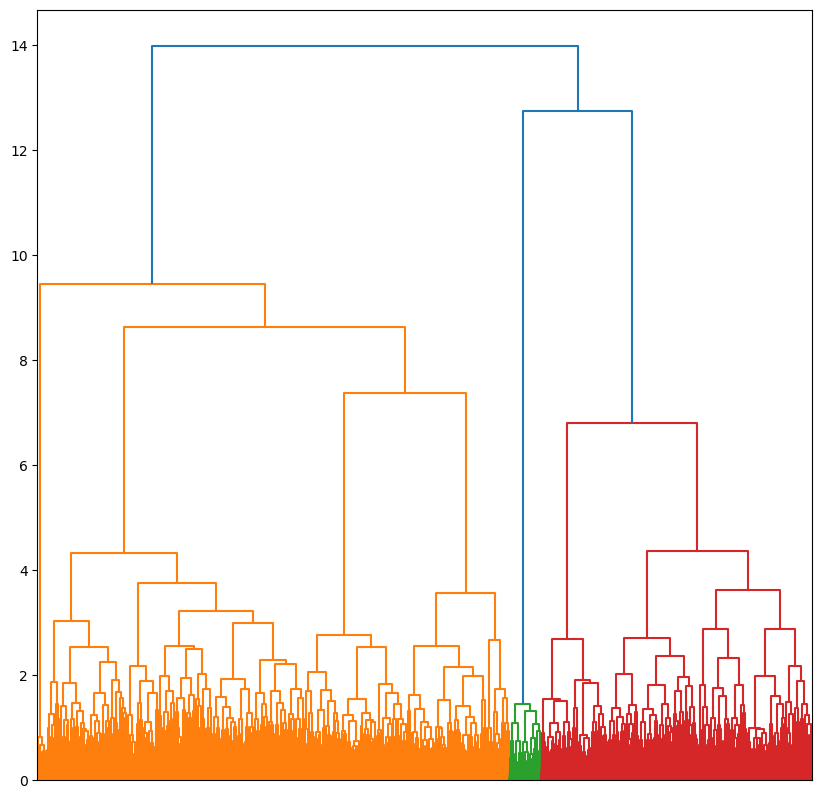

In [25]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [26]:
final_cutoff = 2.5

In [27]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
# clusters_description = regional_ward_morphotopes_data.groupby(final_clusters).mean()
# clusters_description = grouped_data.groupby(final_clusters).mean()
final_clusters.value_counts()

21    5131
14    4443
9     4314
8     3655
23    3295
4     3291
24    3280
10    3142
11    3061
7     3036
19    3016
17    2713
5     2705
12    2692
18    2646
20    2640
3     2568
13    2304
25    2270
6     1437
16    1407
2     1067
22     965
1      836
15     580
Name: count, dtype: int64

### Plotting

In [28]:


from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [79]:
# region_id = 69333 


# region_id = 8707
# region_id = 5883

# region_id = 86873
# region_id = 38679
# region_id = 55763
# region_id = 107131
region_id = 99886
region_id = 151676
# region_id= 66593

In [80]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [81]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

# etcs['final'] = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)

In [82]:
# ## can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [83]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [84]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.26 s, sys: 176 ms, total: 1.44 s
Wall time: 1.44 s


In [85]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [86]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [284]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')
colorcodes.nunique()

NameError: name 'merged_clusters' is not defined

In [ ]:
etcs.final.value_counts().shape


### Interactive dendro

In [39]:
from core import interactive_dendrogram
import jscatter
import ipywidgets

scatter_df = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)

def get_subcluster_children(focus):
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

click_history = dict()
click_history_descriptions = dict()

In [40]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', height=640, width=1280)
scatter.axes(grid=True)
scatter.connect(by='group1', order='order1')
scatter.options({ 'pointConnectionTolerance': 1 })

# output = ipywidgets.Output()

# @output.capture(clear_output=True)
# def selection_change_handler(change):
#     display(scatter_df.loc[change.new].style.hide(axis='index'))
            
# scatter.widget.observe(selection_change_handler, names=["selection"])

# ipywidgets.HBox([scatter.show(), output])

In [41]:
scatter.show()

In [48]:
selected_node = scatter.selection()[0]

n = linkage_matrix.shape[0] + 1

left = scatter_df.loc[selected_node, 'child'].astype(int)
right = scatter_df.loc[selected_node, 'parent'].astype(int)

left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [452]:
left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()
# assert np.isclose(pd.DataFrame({1:left_data, 2: right_data}).T.values, clusters_description.values).all()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

xcnSCl    0.859590
lcdMes    0.267770
linPDE   -0.211615
ldsCDL   -0.200587
ltcWRB    0.170638
linP4W    0.144011
stbSAl   -0.116890
sdsAre   -0.111094
mtbAli   -0.098993
midRea    0.097615
linP3W    0.093684
sssLin    0.092746
sicCAR    0.089543
sddAre   -0.081208
sdsSPO   -0.080879
mtcWNe    0.077809
sdcLAL   -0.074428
sscCCo    0.073928
mdcAre   -0.072394
mtdMDi   -0.070681
dtype: float64

In [79]:
selected_node

np.uint32(1876)

In [80]:
used_keys['ldsCDL']

'local cul-de-sac length of street network'

In [199]:
## save for cutting...
click_history[selected_node] = diffs

In [200]:
click_history_descriptions[selected_node] = 'seperate houses and some blocks'

In [201]:
click_history_descriptions

{np.uint32(149763): 'seperate industry and blocks',
 np.uint32(54716): 'seperate blocks and houses',
 np.uint32(149761): 'seperate blocks and small industry/commercial',
 np.uint32(89156): 'seperate small industry/commercial and houses',
 np.uint32(172212): 'seperate small houses and village centres',
 np.uint32(164548): 'seperate houses and some blocks'}

In [477]:
# selected_nodes = [np.uint32(111423),
#  np.uint32(33393),
#  np.uint32(38449),
#  np.uint32(37855),
#  np.uint32(148429),
#  np.uint32(72344),
#  np.uint32(146708),
#  np.uint32(121375),
#  np.uint32(47156),
#  np.uint32(63627),
#  np.uint32(113183),
#  np.uint32(33392),
# np.uint32(33391)
#                  ]

# # selected_nodes = click_history.keys()

In [478]:
## assign clusters

In [479]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

grouping = pd.DataFrame()
grouping[final_cutoff] = final_clusters.astype(str)

In [480]:


# for selected_node in [6421, 6887, 28557, 15017, 35908]: - hierarchy without lithuania


for selected_node in click_history_descriptions.keys():
    left = scatter_df.loc[selected_node, 'child'].astype(int)
    right = scatter_df.loc[selected_node, 'parent'].astype(int)
    
    left_children = get_subcluster_children(left)
    right_children = get_subcluster_children(right)
    
    grouping.loc[left_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '1'
    grouping.loc[right_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '2'

In [481]:
ordered_columns = grouping.columns.sort_values()
grouping = grouping[ordered_columns]

# forward cluster breakdowns to higher levels
for i, col in enumerate(ordered_columns[:-1]):
    grouping.iloc[grouping[col].notna().values, i + 1] = grouping.loc[grouping[col].notna(), col]  

In [482]:

merged_clusters = grouping[final_cutoff]
merged_clusters = pd.Series(merged_clusters.factorize()[0], merged_clusters.index)

In [483]:
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [484]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')

In [485]:
click_history_descriptions

{np.uint32(94142): '69333_849_123 vinohrady split from medieval and noise',
 np.uint32(31594): '69333_849_15 medieval split from vinohrady and noise',
 np.uint32(64720): '86873_2159_1 sparse ajacant structures from sparse hosues and industry',
 np.uint32(127851): '69333_849_529 split of sparse from industrial + block housing',
 np.uint32(62541): '69333_849_746 split ofindustrial and block housing',
 np.uint32(33467): '69333_849_325 transitionary (vinohrady-like) from houses',
 np.uint32(21206): '5883_0_80 freiburg city centre from row housing',
 np.uint32(27994): '5883_0_12 freiburg  row housing from others',
 np.uint32(29416): '5883_0_225 freiburg almost blocks from square shaped housing ',
 np.uint32(18881): '5883_0_75 freiburg houses from apartment like',
 np.uint32(123368): '38679_5_1590 seperate industry and some blocks',
 np.uint32(62309): '99886_144_25 seperate industry and some blocks',
 np.uint32(62308): '151675_568_41 seperate industry and some blocks',
 np.uint32(125859): '1

In [486]:
scatter_df.loc[click_history_descriptions.keys()]

,child,parent,dist,size,x,y,group1,order1
94142,129282.0,129318.0,3.974562,1422.0,5.723044e+05,3.974562,64695.0,3
31594,127324.0,128036.0,2.936556,251.0,6.281379e+05,2.936556,64465.0,3
64720,129406.0,129408.0,4.971145,2412.0,1.265906e+06,4.971145,64714.0,2
127851,129127.0,129235.0,3.608248,818.0,1.252657e+06,3.608248,64680.0,3
62541,118430.0,120738.0,2.032077,54.0,1.250198e+06,2.032077,59912.0,1
33467,129353.0,129356.0,4.159924,971.0,6.600612e+05,4.159924,64673.0,2
21206,129113.0,129308.0,3.961836,1170.0,4.091271e+05,3.961836,64645.0,2
27994,129388.0,129398.0,4.374658,6789.0,4.897929e+05,4.374658,64690.0,2
29416,128841.0,128978.0,3.747684,665.0,5.815084e+05,3.747684,64647.0,1
18881,129395.0,129397.0,4.618155,2742.0,3.459715e+05,4.618155,64706.0,2


In [487]:
merged_clusters.value_counts().sort_index()

0      3284
1       785
2      3505
3      1144
4     12110
5      1156
6      1598
7     10601
8      1558
9      4025
10      429
11     1454
12     5520
13     4455
14     1165
15      281
16      515
17      211
18      335
19      140
20     4545
21      525
22     2830
23      446
24      757
25       40
26       13
27      294
28      371
29      137
30      385
31       41
32        3
33       38
34       15
35        7
36        8
Name: count, dtype: int64

In [491]:
pd.Series(click_history_descriptions).to_csv('/data/uscuni-ulce/processed_data/clusters/manual_cuts_v1.csv')

In [488]:
merged_clusters.to_frame().to_parquet('/data/uscuni-ulce/processed_data/clusters/clusters_v1.pq')

In [ ]:
final_clusters = pd.read_parquet('/data/uscuni-ulce/processed_data/clusters/clusters_v1.pq')[0]
cdata = grouped_data.groupby(final_clusters).median().fillna(0)
cdata.to_parquet('/data/uscuni-ulce/processed_data/clusters/cdata_v1.pq')

## hierarchy of final clusters

In [ ]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)


In [707]:
fdata.to_parquet('../data/cluster_data.pq')


In [600]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)
scalar = StandardScaler()
vals = scalar.fit_transform(fdata)
fdata = pd.DataFrame(vals, index=fdata.index, columns=fdata.columns)

In [601]:
linkage = 'complete'
metric = 'euclidean'
linkage_matrix = get_morphotope_linkage(fdata)

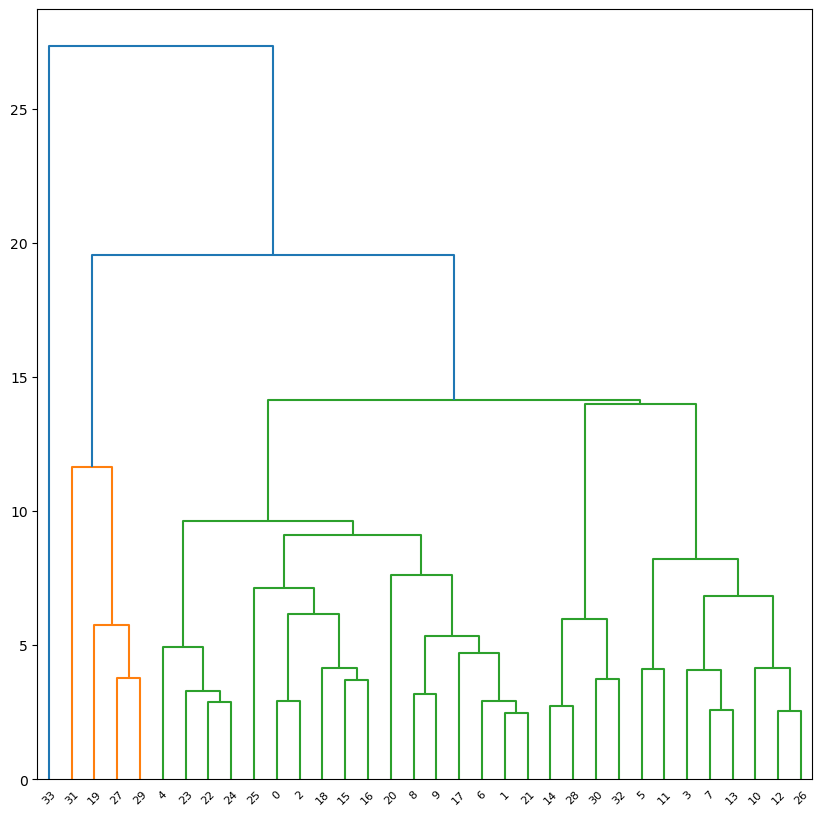

In [602]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax)

In [622]:
etcs[etcs.final == 28].explore(prefer_canvas=True, tiles='cartodb.positron')

In [574]:
final_cutoff = 8
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, fdata.index)
final_clusters.value_counts()

5    7
4    6
8    6
3    4
6    4
1    3
7    2
2    1
9    1
Name: count, dtype: int64

## assign to etcs

In [89]:
from core.cluster_validation import get_color
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [90]:
region_id = 5883

In [91]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
etcs.shape

(70893, 8)

In [92]:
# region_hulls.explore()

In [93]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

In [94]:
# etcs['final'] = etcs.final.map(final_clusters).values

In [180]:
region_hulls

,convex_hull
labels,
4,"POLYGON ((4122200 3045600, 4121500 3045900, 40..."
10,"POLYGON ((4068900 3057300, 4051000 3064300, 40..."
132,"POLYGON ((4053100 3049800, 4050900 3053000, 40..."
134,"POLYGON ((4052500 3093600, 4052200 3093700, 40..."
286,"POLYGON ((4060600 3103900, 4057000 3104200, 40..."
...,...
149997,"POLYGON ((5253200 3642300, 5245600 3647000, 52..."
150044,"POLYGON ((5265700 3578300, 5263400 3578400, 52..."
151676,"POLYGON ((5285400 3549200, 5284800 3549900, 52..."


In [95]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = merged_colors.loc[etcs.final].values.astype('uint8')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 271 ms, sys: 35.9 ms, total: 307 ms
Wall time: 301 ms


In [96]:
# layer.get_fill_color = get_color(etcs.final.map(final_clusters).values.astype(int))

In [97]:
etcs.final.nunique()

24

In [780]:
etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

In [25]:
merged_colors.shape

(36, 3)

### Assign all regions

In [492]:
merged_clusters = pd.read_parquet('/data/uscuni-ulce/processed_data/clusters/clusters_v1.pq')[0]
merged_clusters.nunique()

37

In [493]:
%%time
for region_id, _ in region_hulls.iterrows():
    print(region_id)
    etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
    etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
    etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")
    etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [494]:
fdata = regional_ward_morphotopes_data.groupby(merged_clusters).median()

In [495]:
fdata.to_parquet('/data/uscuni-ulce/processed_data/clusters/fdata.pq')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pandas/io/parquet.py:480: UserWarning: The DataFrame has non-str index name `[np.int64(0)]` which will be converted to string and not roundtrip correctly.
  impl.write(


In [23]:
fdata.loc[[12, 14]].style.background_gradient(axis=1, cmap="BuGn")

NameError: name 'fdata' is not defined

### Tree comparisons

In [224]:
from sklearn.neighbors import KDTree

In [225]:
tree = KDTree(regional_ward_morphotopes_data.values)

In [527]:
dists, idxs = tree.query(regional_ward_morphotopes_data.loc[['69333_66']], k=100)

In [528]:
regional_ward_morphotopes_data.iloc[idxs[0]].index

Index(['69333_66', '62954_18', '114311_66', '35141_1', '97745_5', '78792_11',
       '1154_19', '109491_60', '105385_4', '107131_445', '97745_3',
       '105090_15', '78938_32', '93793_17', '72396_10', '61183_2', '116866_31',
       '107131_447', '86873_39', '67156_11', '62954_16', '83538_29',
       '80404_68', '18557_91', '51289_3', '130658_17', '64220_42', '75642_5',
       '62193_4', '90196_6', '87947_3', '93167_16', '73611_9', '107131_441',
       '114311_65', '84554_38', '108884_27', '1154_18', '61187_17',
       '109491_63', '110908_2', '103561_13', '107131_456', '90770_55',
       '67803_4', '93504_7', '82514_3', '120961_8', '114311_64', '78938_31',
       '53525_2', '86863_4', '116866_32', '97745_6', '90075_1', '93793_10',
       '103713_6', '88950_2', '96465_1', '97978_10', '84962_7', '128286_16',
       '93167_15', '109491_59', '80313_11', '102814_9', '84420_6', '55763_24',
       '85156_4', '89921_2', '72507_21', '76038_20', '129730_34', '82773_14',
       '96727_11', '7547

In [139]:
# etcs[etcs.regional == '69333_64'].explore()